In [1]:
#%run ../Exploring_data/Exploratory_analysis.ipynb

# Number of days for the prediction

In the next line we are going to choose the number of days we want to predict. For this project we have chosen 7 days, but it can be changed for investigating:

In [2]:
days = 28

## XGBoost with shuffled data:

For this model, we are considering a regressor model where all the data is picked up randomly. 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

# After importing the modules, we are defining our functions:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

We read the data

In [4]:
# We read the data:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

It is important to considerate the time that we want to predict. If we want to know the price for 1 week, we will need to shift the target column X days so, with the information we have today, we can predict the value for the electricity in X days:

In [5]:
# We multiply the number of days that we want to predict by 24 and then we drop the rows without target:
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-24*days)
df.dropna(axis=0,how='any',inplace=True)

Then we select the columns that we will use:

In [6]:
model_columns = ['Demanda_programada_P48_total', 
                  'Demanda_programada_P48_Correccion_eolica',
                  'Demanda_programada_P48_Correccion_solar',
                  'Precio_mercado_SPOT_Diario',
                  'Precio_mercado_SPOT_Intradiario_Sesion_1',
                  'Precio_mercado_SPOT_Intradiario_Sesion_2',
                  'Precio_mercado_SPOT_Intradiario_Sesion_3',
                  'Precio_mercado_SPOT_Intradiario_Sesion_4',
                  'Precio_mercado_SPOT_Intradiario_Sesion_5',
                  'Precio_mercado_SPOT_Intradiario_Sesion_6',
                  'Precio_mercado_SPOT_Intradiario_Sesion_7',
                  'Generacion_programada_P48_Biogas',
                  'Generacion_programada_P48_Biomasa',
                  'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                  'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                  'Generacion_programada_P48_Turbinacion_bombeo',
                 'Consumer_price_index', 
                 'Time_required_to_get_electricity_(days)',
                 'Inflation,consumer_prices_(annual_%)',
                 'Employment_in_industry_(%_of_total_employment)', 
                 'PIB_Trimestral', 
                 'Var_Trim_PIB_(%)', 
                 'Var_anual_PIB_Trim_(%)',
                 'IBEX35',
                 'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29','Day_30'
                ]

After selecting the columns, we have to split the data into train, validation for the model and test.

In [7]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
# Let's get the last index for our model:
last_value = y.shape[0]-days*24
# We split train and test with a ratio of 0.8-0.2
X_train_aux, X_test, y_train_aux, y_test = train_test_split(X.iloc[:last_value,], y.iloc[:last_value,], train_size=0.8,test_size=0.2, random_state=101)
# From the train, we take out a 0.2 portion of the dataframe for validating the model:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_aux, y_train_aux, train_size=0.8,test_size=0.2, random_state=101)
# For our project:
X_test_days = X.iloc[last_value:,]
y_test_days = y.iloc[last_value:,]

Then, we look for the best model. In order to achieve that, we will use GridSearchCV, which allow us to do a Cross Validation and fit for the best model with the parameters we try on it:

In [8]:
# Let's create the model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 20, n_estimators = 200, early_stopping_rounds = 15)
# Parameters to check
parameters = {'colsample_bytree':[0.4,0.3],'learning_rate': [0.1,0.15,0.2],
                'max_depth': [5,7,9]}
# Create the GridSearchCV
xgb_mod = GridSearchCV(xg_reg,cv=5,verbose=1,param_grid=parameters,
                       scoring='neg_mean_squared_error',n_jobs=-1, error_score='raise')

We fit the GridSearchCV so we find the best suitable model:

In [9]:
%%time
xgb_mod.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.1min finished


CPU times: user 1min 1s, sys: 2.16 s, total: 1min 3s
Wall time: 8min 13s


GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRegressor(alpha=20, base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.3,
                                    early_stopping_rounds=15, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=None,
                                    missing=nan, m...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='warn', n_job

In [10]:
print('El RMSE para nuestro mejor modelo es: ',np.sqrt(abs(xgb_mod.best_score_)))

El RMSE para nuestro mejor modelo es:  5.523762273933596


After that, we fit our best model into our data:

In [11]:
eval_set = [(X_train, y_train), (X_validation, y_validation)]
# Let's check the results
xgb_mod.best_estimator_.fit(X_train,y_train,eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:81.06060	validation_0-mae:73.60478	validation_1-rmse:80.27451	validation_1-mae:72.82382
[1]	validation_0-rmse:65.18445	validation_0-mae:58.93666	validation_1-rmse:64.57515	validation_1-mae:58.33096
[2]	validation_0-rmse:52.81621	validation_0-mae:47.26669	validation_1-rmse:52.33473	validation_1-mae:46.78013
[3]	validation_0-rmse:43.30199	validation_0-mae:38.04493	validation_1-rmse:42.93470	validation_1-mae:37.62660
[4]	validation_0-rmse:35.75450	validation_0-mae:30.79225	validation_1-rmse:35.49948	validation_1-mae:30.46816
[5]	validation_0-rmse:29.17462	validation_0-mae:24.95995	validation_1-rmse:29.02199	validation_1-mae:24.75365
[6]	validation_0-rmse:24.03911	validation_0-mae:20.36064	validation_1-rmse:23.97674	validation_1-mae:20.27183
[7]	validation_0-rmse:20.05889	validation_0-mae:16.79339	validation_1-rmse:20.08336	validation_1-mae:16.80198
[8]	validation_0-rmse:17.25658	validation_0-mae:14.20445	validation_1-rmse:17.35688	validation_1-mae:14.27831
[9]	valida

[77]	validation_0-rmse:4.77524	validation_0-mae:3.66116	validation_1-rmse:6.14068	validation_1-mae:4.65725
[78]	validation_0-rmse:4.75321	validation_0-mae:3.64490	validation_1-rmse:6.12782	validation_1-mae:4.64791
[79]	validation_0-rmse:4.72933	validation_0-mae:3.62463	validation_1-rmse:6.11313	validation_1-mae:4.63553
[80]	validation_0-rmse:4.71627	validation_0-mae:3.61372	validation_1-rmse:6.10373	validation_1-mae:4.62799
[81]	validation_0-rmse:4.69748	validation_0-mae:3.59850	validation_1-rmse:6.08852	validation_1-mae:4.61663
[82]	validation_0-rmse:4.67776	validation_0-mae:3.58339	validation_1-rmse:6.07726	validation_1-mae:4.60679
[83]	validation_0-rmse:4.65292	validation_0-mae:3.56493	validation_1-rmse:6.06458	validation_1-mae:4.59763
[84]	validation_0-rmse:4.61973	validation_0-mae:3.54063	validation_1-rmse:6.03908	validation_1-mae:4.57830
[85]	validation_0-rmse:4.60613	validation_0-mae:3.52933	validation_1-rmse:6.03231	validation_1-mae:4.57179
[86]	validation_0-rmse:4.58095	valida

[154]	validation_0-rmse:3.52842	validation_0-mae:2.68308	validation_1-rmse:5.38882	validation_1-mae:4.07034
[155]	validation_0-rmse:3.51931	validation_0-mae:2.67617	validation_1-rmse:5.38447	validation_1-mae:4.06719
[156]	validation_0-rmse:3.50614	validation_0-mae:2.66645	validation_1-rmse:5.37716	validation_1-mae:4.06171
[157]	validation_0-rmse:3.50326	validation_0-mae:2.66410	validation_1-rmse:5.37521	validation_1-mae:4.06026
[158]	validation_0-rmse:3.49678	validation_0-mae:2.65853	validation_1-rmse:5.37411	validation_1-mae:4.05875
[159]	validation_0-rmse:3.49463	validation_0-mae:2.65665	validation_1-rmse:5.37254	validation_1-mae:4.05757
[160]	validation_0-rmse:3.48325	validation_0-mae:2.64885	validation_1-rmse:5.36762	validation_1-mae:4.05291
[161]	validation_0-rmse:3.47234	validation_0-mae:2.63987	validation_1-rmse:5.36094	validation_1-mae:4.04736
[162]	validation_0-rmse:3.46122	validation_0-mae:2.63113	validation_1-rmse:5.35464	validation_1-mae:4.04232
[163]	validation_0-rmse:3.44

XGBRegressor(alpha=20, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, early_stopping_rounds=15,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.2, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=20, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

We can have a look into the most important features in the model:

In [12]:
# We print a dataframe with the importance of each feature:
pd.DataFrame(xgb_mod.best_estimator_.feature_importances_.reshape(1, -1), columns=X.columns)

,Demanda_programada_P48_total,Demanda_programada_P48_Correccion_eolica,Demanda_programada_P48_Correccion_solar,Precio_mercado_SPOT_Diario,Precio_mercado_SPOT_Intradiario_Sesion_1,Precio_mercado_SPOT_Intradiario_Sesion_2,Precio_mercado_SPOT_Intradiario_Sesion_3,Precio_mercado_SPOT_Intradiario_Sesion_4,Precio_mercado_SPOT_Intradiario_Sesion_5,Precio_mercado_SPOT_Intradiario_Sesion_6,...,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30
0,0.004014,0.000218,0.004096,0.016458,0.008648,0.001711,0.000879,0.04364,0.136708,0.276288,...,0.000569,0.000672,0.000693,0.000765,0.000461,0.000426,0.000375,0.000641,0.000834,0.000345


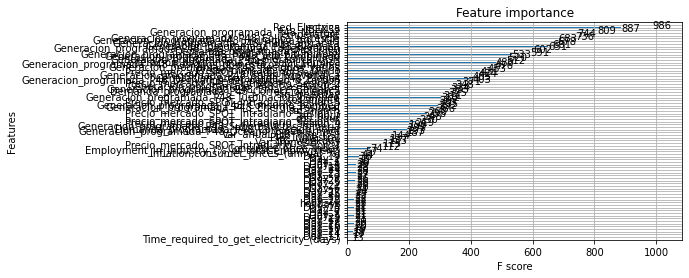

In [13]:
xgb.plot_importance(xgb_mod.best_estimator_)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

Then we calculate our prediction and check the metrics:

In [14]:
y_pred = xgb_mod.best_estimator_.predict(X_test) 
print('Se obtiene un RMSE de ',np.sqrt(mean_squared_error(y_test, y_pred)),', un R2 de ',r2_score(y_test, y_pred),' y un MAPE de',mean_absolute_percentage_error(y_test, y_pred))

Se obtiene un RMSE de  5.258026923040707 , un R2 de  0.9815674130875949  y un MAPE de 5.467812321123662


Last, we plot the results:

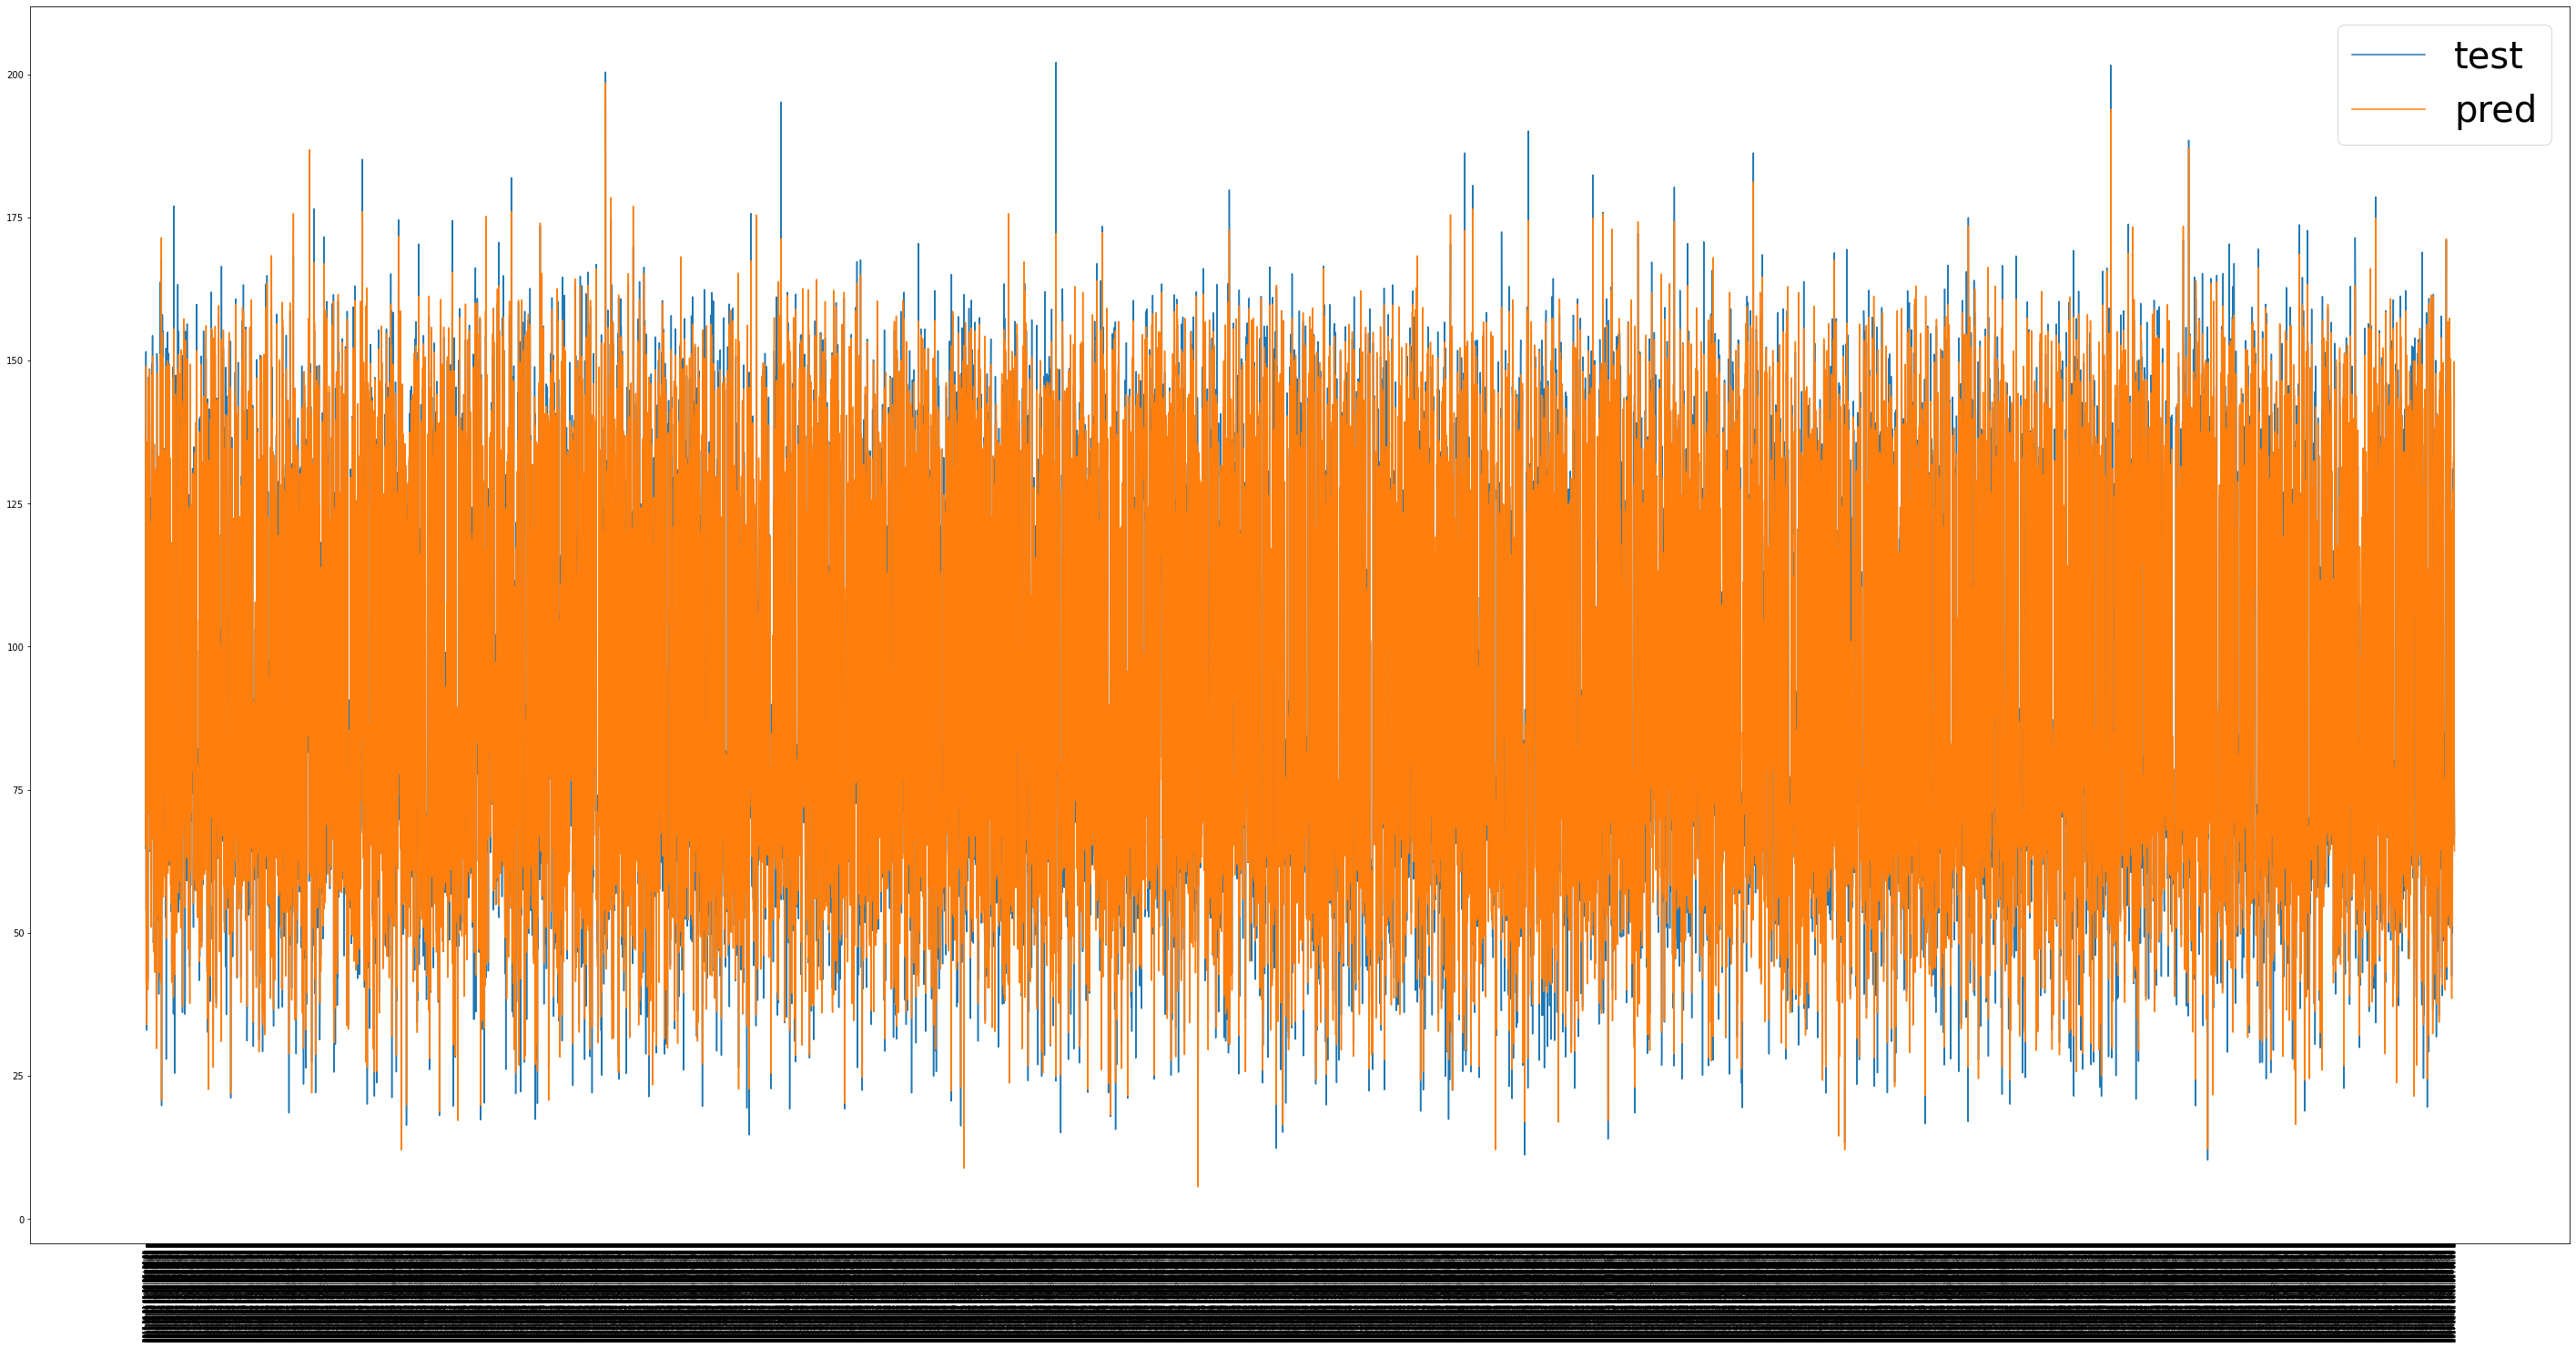

In [15]:
plt.rcParams['figure.figsize'] = [50, 25]
plt.plot(y_test, label='test')
plt.plot(y_pred, label='pred')
plt.legend(prop={'size': 40})
plt.xticks(rotation=90, fontsize = 7)
plt.show()

Checking the forecasting for the last days:

Para los resultados de las últimas 4 semanas se obtiene un RMSE de  5.775169854352853 , un R2 de  0.9713156199403902  y un MAPE de 7.624060364902586


/home/joeldela/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


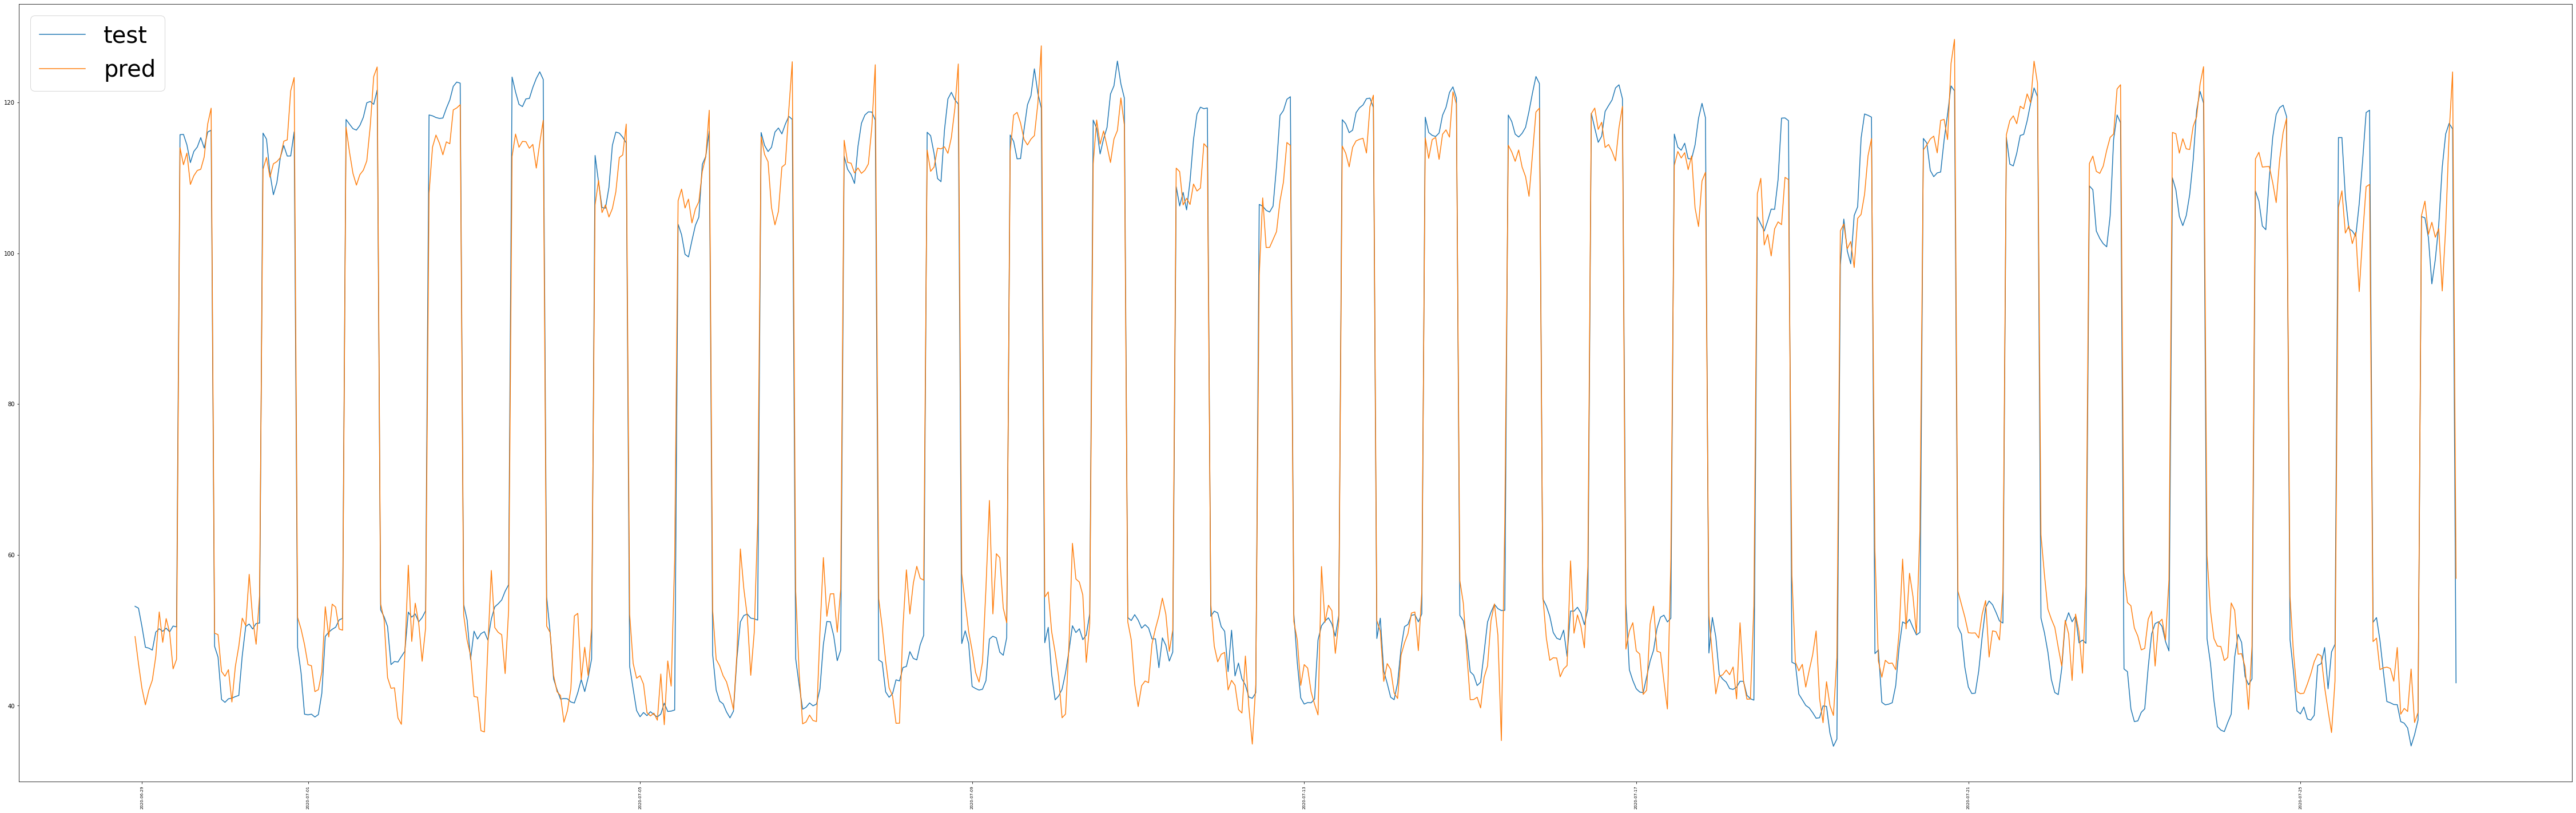

In [16]:
# Let's predict 
y_pred_days = xgb_mod.best_estimator_.predict(X_test_days) 
y_test_days.index =  pd.to_datetime(y_test_days.index)
# Give index to the arrays:
y_pred_days = pd.Series(y_pred_days, index = y_test_days.index)
y_pred_days.index =  pd.to_datetime(y_pred_days.index)
print('Para los resultados de las últimas 4 semanas se obtiene un RMSE de ',np.sqrt(mean_squared_error(y_test_days, y_pred_days)),', un R2 de ',r2_score(y_test_days, y_pred_days),' y un MAPE de',mean_absolute_percentage_error(y_test_days, y_pred_days))
#Let's plot the results
plt.rcParams['figure.figsize'] = [80, 25]
plt.plot(y_test_days, label='test')
plt.plot(y_pred_days, label='pred')
plt.legend(prop={'size': 40})
plt.xticks(rotation=90, fontsize = 7)
plt.show()

Finally, we export the results for the visualization

In [17]:
pd.DataFrame({'test':y_test_days, 'prediccion':y_pred_days},index = y_test_days.index).to_csv('./../Visualization/Xgboost_shuffled.csv')

## XGBoost with sorted data:

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

# After importing the modules, we are defining our functions:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
# We read the data:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

It is important to considerate the time that we want to predict. If we want to know the price for 1 week, we will need to shift the target column X days so, with the information we have today, we can predict the value for the electricity in X days:

In [20]:
# We multiply the number of days that we want to predict by 24 and then we drop the rows without target:
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-24*days)
df.dropna(axis=0,how='any',inplace=True)

Then we select the columns that we will use:

In [21]:
model_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Precio_mercado_SPOT_Intradiario_Sesion_3',
                 'Precio_mercado_SPOT_Intradiario_Sesion_4',
                 'Precio_mercado_SPOT_Intradiario_Sesion_5',
                 'Precio_mercado_SPOT_Intradiario_Sesion_6',
                 'Precio_mercado_SPOT_Intradiario_Sesion_7',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 'Consumer_price_index', 
                 'Time_required_to_get_electricity_(days)',
                 'Inflation,consumer_prices_(annual_%)',
                 'Employment_in_industry_(%_of_total_employment)', 
                 'PIB_Trimestral', 
                 'Var_Trim_PIB_(%)', 
                 'Var_anual_PIB_Trim_(%)',
                 'IBEX35',
                 'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

standarized_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Precio_mercado_SPOT_Intradiario_Sesion_3',
                 'Precio_mercado_SPOT_Intradiario_Sesion_4',
                 'Precio_mercado_SPOT_Intradiario_Sesion_5',
                 'Precio_mercado_SPOT_Intradiario_Sesion_6',
                 'Precio_mercado_SPOT_Intradiario_Sesion_7',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 'Consumer_price_index', 
                 'Time_required_to_get_electricity_(days)',
                 'Inflation,consumer_prices_(annual_%)',
                 'Employment_in_industry_(%_of_total_employment)', 
                 'PIB_Trimestral', 
                 'Var_Trim_PIB_(%)', 
                 'Var_anual_PIB_Trim_(%)',
                 'IBEX35',
                 'Red_Electrica',
                 'Temperature']

After selecting the columns, we have to split the data into train, validation for the model and test.

In [22]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']

last_value = y.shape[0]-days*24

y_train = y.iloc[:last_value,]
X_train = X.iloc[:last_value,]
y_test = y.iloc[last_value:,]
X_test = X.iloc[last_value:,]

Then, we look for the best model. In order to achieve that, we will use GridSearchCV, which allow us to do a Cross Validation and fit for the best model with the parameters we try on it:

In [23]:
# Let's create the model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 20, n_estimators = 200, early_stopping_rounds = 15)
# Parameters to check
parameters = {'colsample_bytree':[0.4,0.3],'learning_rate': [0.1,0.15,0.2],
                'max_depth': [5,7,9]}
# Create the GridSearchCV
xgb_mod = GridSearchCV(xg_reg,cv=5,verbose=1,param_grid=parameters,
                       scoring='neg_mean_squared_error',n_jobs=-1, error_score='raise')

We fit the GridSearchCV so we find the best suitable model:

In [24]:
%%time
xgb_mod.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 13.0min finished


CPU times: user 1min 30s, sys: 4.84 s, total: 1min 35s
Wall time: 13min 15s


GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRegressor(alpha=20, base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.3,
                                    early_stopping_rounds=15, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=None,
                                    missing=nan, m...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='warn', n_job

In [25]:
print('El RMSE para nuestro mejor modelo es: ',np.sqrt(abs(xgb_mod.best_score_)))

El RMSE para nuestro mejor modelo es:  16.4151662841845


After that, we fit our best model into our data:

In [26]:
eval_set = [(X_train, y_train), (X_test, y_test)]
# Let's check the results
xgb_mod.best_estimator_.fit(X_train,y_train,eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:85.49773	validation_0-mae:77.95809	validation_1-rmse:69.89582	validation_1-mae:63.21922
[1]	validation_0-rmse:72.89658	validation_0-mae:66.28706	validation_1-rmse:59.91090	validation_1-mae:54.14771
[2]	validation_0-rmse:62.43552	validation_0-mae:56.39598	validation_1-rmse:52.07959	validation_1-mae:46.40257
[3]	validation_0-rmse:53.80788	validation_0-mae:48.03935	validation_1-rmse:44.43067	validation_1-mae:38.56405
[4]	validation_0-rmse:46.54996	validation_0-mae:40.98221	validation_1-rmse:37.83838	validation_1-mae:32.30292
[5]	validation_0-rmse:39.90087	validation_0-mae:34.97657	validation_1-rmse:32.21323	validation_1-mae:27.23378
[6]	validation_0-rmse:34.32702	validation_0-mae:29.89729	validation_1-rmse:27.60729	validation_1-mae:23.29793
[7]	validation_0-rmse:29.64411	validation_0-mae:25.63763	validation_1-rmse:23.65283	validation_1-mae:19.85677
[8]	validation_0-rmse:26.02953	validation_0-mae:22.17450	validation_1-rmse:20.38467	validation_1-mae:16.96198
[9]	valida

[77]	validation_0-rmse:5.40697	validation_0-mae:4.12843	validation_1-rmse:5.62874	validation_1-mae:4.45986
[78]	validation_0-rmse:5.37707	validation_0-mae:4.10614	validation_1-rmse:5.58704	validation_1-mae:4.43224
[79]	validation_0-rmse:5.36539	validation_0-mae:4.09695	validation_1-rmse:5.59536	validation_1-mae:4.43682
[80]	validation_0-rmse:5.34359	validation_0-mae:4.08091	validation_1-rmse:5.59991	validation_1-mae:4.43867
[81]	validation_0-rmse:5.31814	validation_0-mae:4.06172	validation_1-rmse:5.59754	validation_1-mae:4.43905
[82]	validation_0-rmse:5.29019	validation_0-mae:4.04144	validation_1-rmse:5.59014	validation_1-mae:4.43322
[83]	validation_0-rmse:5.27881	validation_0-mae:4.03272	validation_1-rmse:5.58607	validation_1-mae:4.42974
[84]	validation_0-rmse:5.26995	validation_0-mae:4.02560	validation_1-rmse:5.58502	validation_1-mae:4.42850
[85]	validation_0-rmse:5.25664	validation_0-mae:4.01540	validation_1-rmse:5.58562	validation_1-mae:4.43042
[86]	validation_0-rmse:5.21505	valida

[154]	validation_0-rmse:4.19031	validation_0-mae:3.20004	validation_1-rmse:5.62580	validation_1-mae:4.49162
[155]	validation_0-rmse:4.18051	validation_0-mae:3.19206	validation_1-rmse:5.58863	validation_1-mae:4.46214
[156]	validation_0-rmse:4.16479	validation_0-mae:3.18070	validation_1-rmse:5.59277	validation_1-mae:4.46549
[157]	validation_0-rmse:4.15940	validation_0-mae:3.17580	validation_1-rmse:5.59327	validation_1-mae:4.46630
[158]	validation_0-rmse:4.14691	validation_0-mae:3.16575	validation_1-rmse:5.59097	validation_1-mae:4.46825
[159]	validation_0-rmse:4.13532	validation_0-mae:3.15680	validation_1-rmse:5.59074	validation_1-mae:4.46824
[160]	validation_0-rmse:4.13014	validation_0-mae:3.15300	validation_1-rmse:5.59067	validation_1-mae:4.46813
[161]	validation_0-rmse:4.11728	validation_0-mae:3.14313	validation_1-rmse:5.58725	validation_1-mae:4.46647
[162]	validation_0-rmse:4.10787	validation_0-mae:3.13547	validation_1-rmse:5.59513	validation_1-mae:4.47269
[163]	validation_0-rmse:4.09

XGBRegressor(alpha=20, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, early_stopping_rounds=15,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.15, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=20, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

We can have a look into the most important features in the model:

In [27]:
# We print a dataframe with the importance of each feature:
pd.DataFrame(xgb_mod.best_estimator_.feature_importances_.reshape(1, -1), columns=X.columns)

,Demanda_programada_P48_total,Demanda_programada_P48_Correccion_eolica,Demanda_programada_P48_Correccion_solar,Precio_mercado_SPOT_Diario,Precio_mercado_SPOT_Intradiario_Sesion_1,Precio_mercado_SPOT_Intradiario_Sesion_2,Precio_mercado_SPOT_Intradiario_Sesion_3,Precio_mercado_SPOT_Intradiario_Sesion_4,Precio_mercado_SPOT_Intradiario_Sesion_5,Precio_mercado_SPOT_Intradiario_Sesion_6,...,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30
0,0.00376,0.000235,0.004524,0.012767,0.014174,0.002593,0.001475,0.037588,0.169977,0.280896,...,0.000344,0.000615,0.000533,0.000548,0.000476,0.000313,0.000299,0.000339,0.000677,0.000693


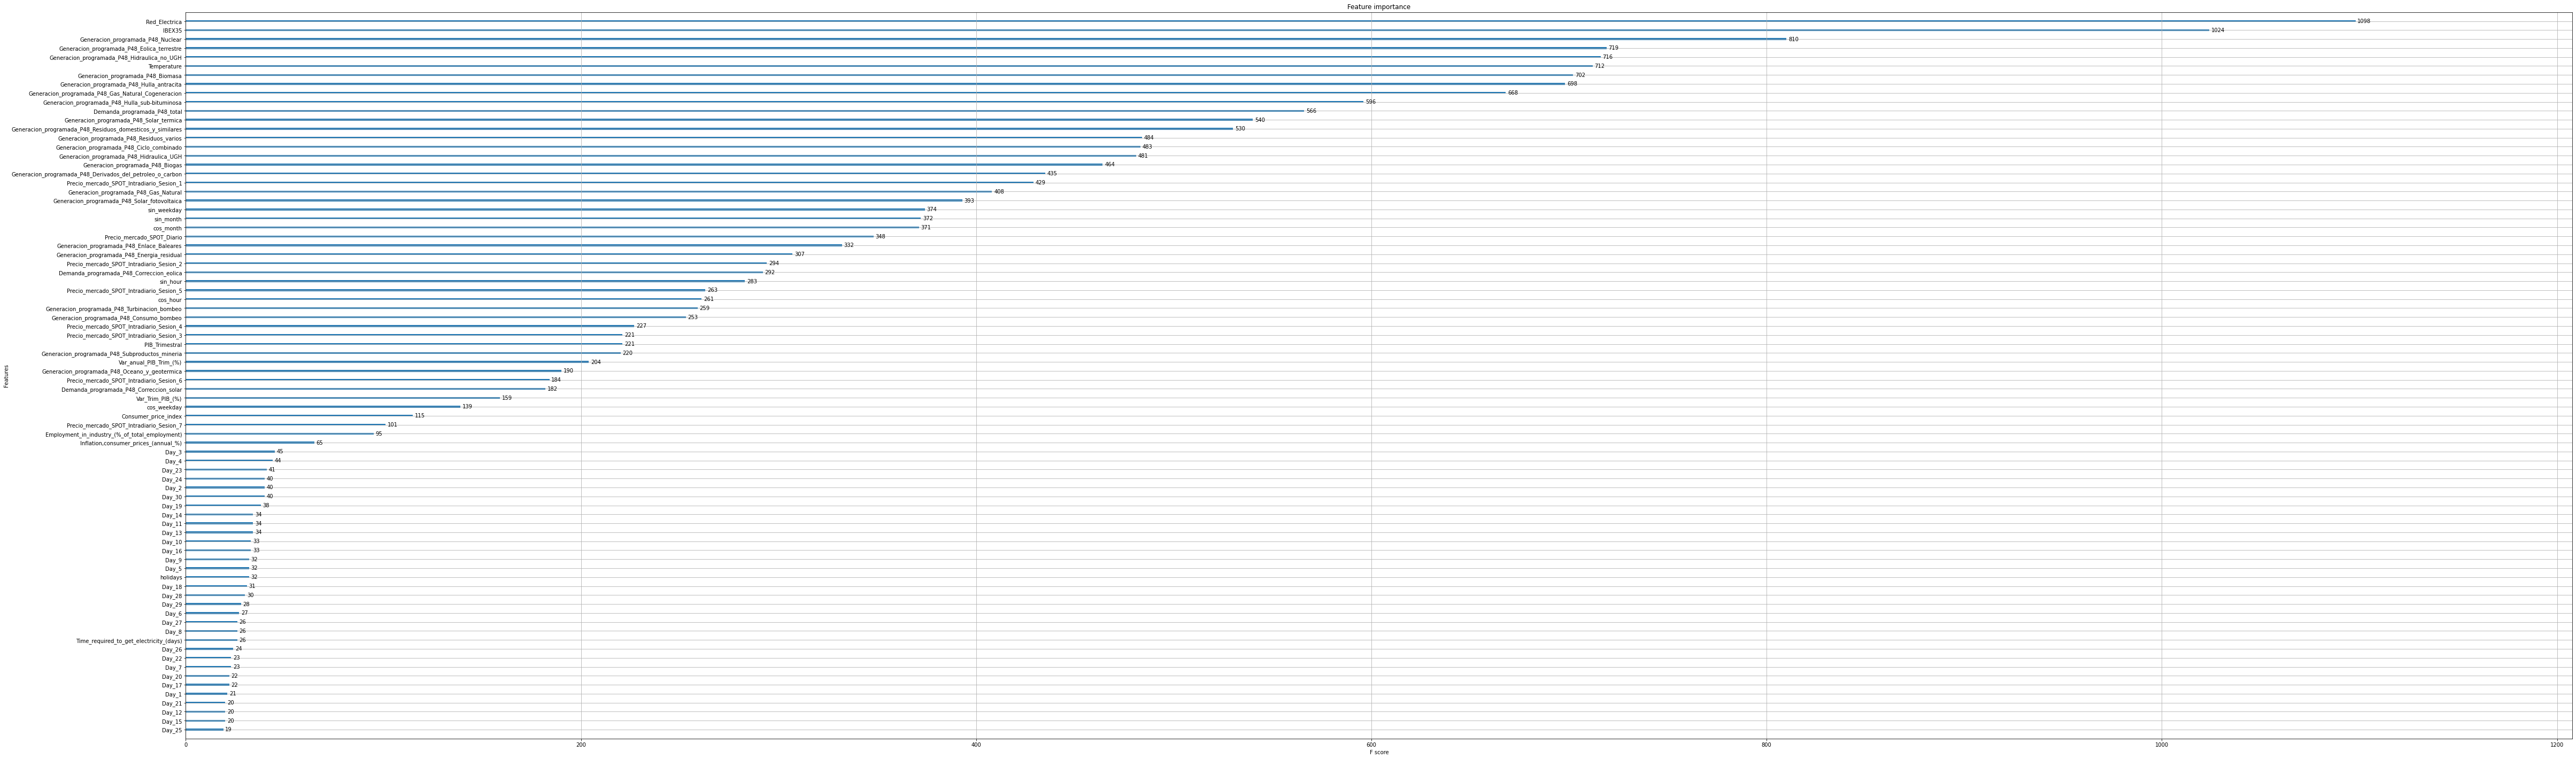

In [28]:
xgb.plot_importance(xgb_mod.best_estimator_)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

Then we calculate our prediction and check the metrics, while plotting the results:

Para los resultados de las últimas 4 semanas se obtiene un RMSE de  5.568784437801235 , un R2 de  0.9733291560326036  y un MAPE de 7.52508847617714


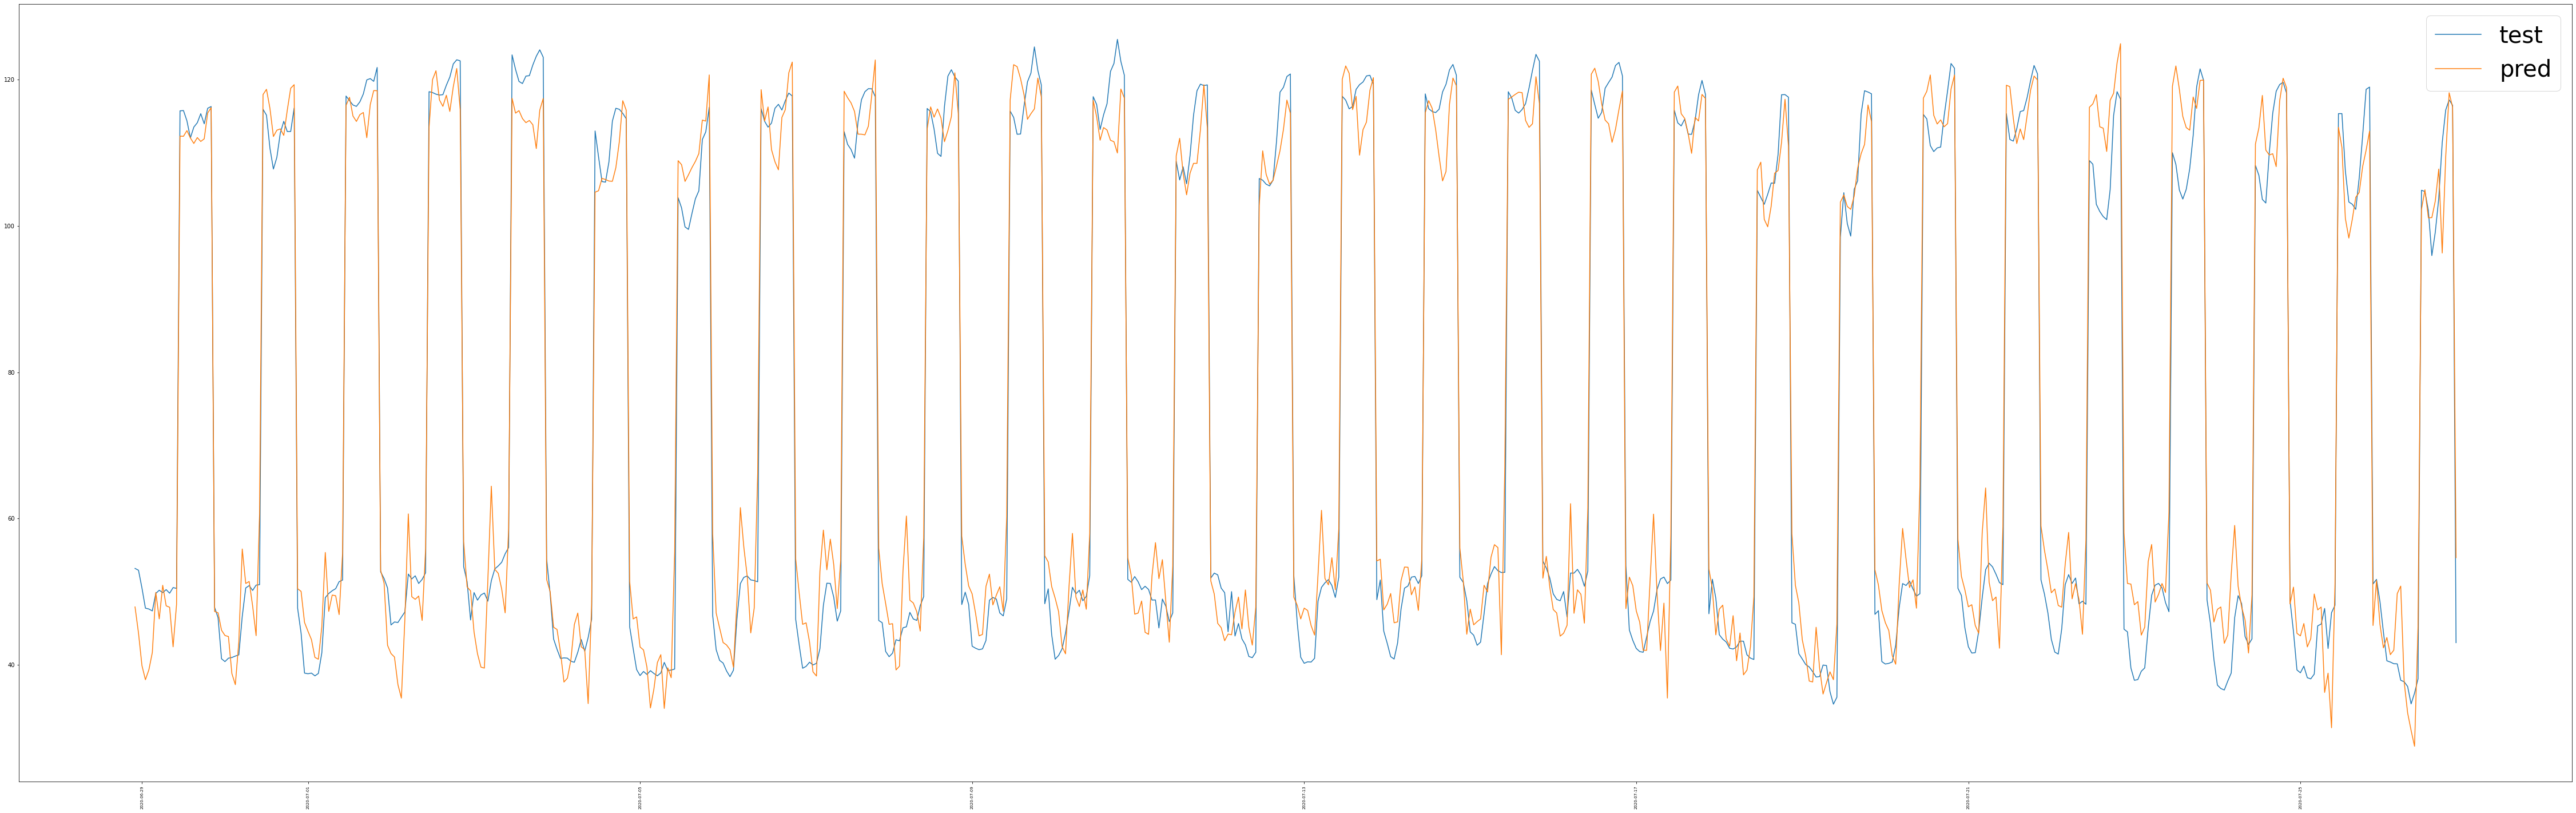

In [29]:
# Let's predict
y_pred = xgb_mod.best_estimator_.predict(X_test) 
y_test.index =  pd.to_datetime(y_test.index)
# Give index to the arrays:
y_pred = pd.Series(y_pred, index = y_test.index)
y_pred.index =  pd.to_datetime(y_pred.index)
# Let's check the metrics and plot the results:
print('Para los resultados de las últimas 4 semanas se obtiene un RMSE de ',np.sqrt(mean_squared_error(y_test, y_pred)),', un R2 de ',r2_score(y_test, y_pred),' y un MAPE de',mean_absolute_percentage_error(y_test, y_pred))
plt.rcParams['figure.figsize'] = [80, 25]
plt.plot(y_test, label='test')
plt.plot(y_pred, label='pred')
plt.legend(prop={'size': 40})
plt.xticks(rotation=90, fontsize = 7)
plt.show()

Finally, we export the results for the visualization

In [30]:
pd.DataFrame({'test':y_test, 'prediccion':y_pred},index = y_test.index).to_csv('./../Visualization/Xgboost_sorted.csv')